In [17]:
%load_ext py_d3
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import qutip
import theano
import theano.tensor as T
from collections import OrderedDict
import itertools
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from qubit_network.QubitNetwork import QubitNetwork
import qubit_network as qn
from qubit_network.net_analysis_tools import *

from utils import *

pairs = list(itertools.combinations(range(4), 2))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Half-adder gate
The half-adder gate is a toffoli gate, followed by a CNOT gate between first and third qubit.

The first two input qubits are the inputs to be summed, the second output qubit is the (half) sum, the third output qubit the carrier, and the first output qubit is ancillary.

In [2]:
halfadder = (qutip.cnot(3, 0, 1) * qutip.toffoli())

<IPython.core.display.Javascript object>


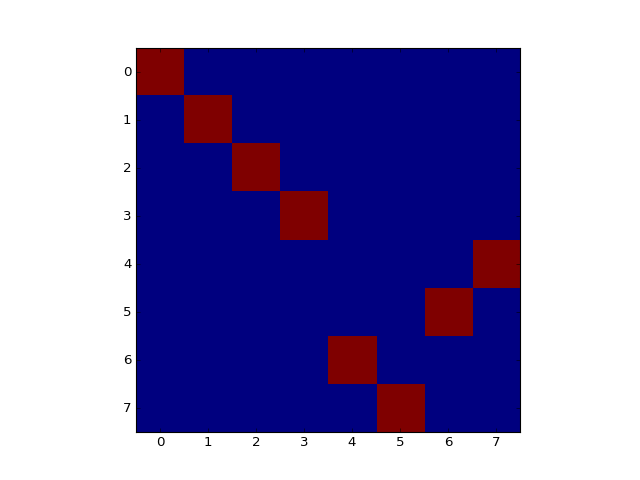

In [42]:
plt.imshow(halfadder.data.toarray().real, interpolation='nearest')

### A Fredkin gate is be obtained with very good fidelity, $\simeq 99.999\%$, starting with all interactions on, and only $\sigma_z$ operators as self-interactions.

In [4]:
halfadder

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]]

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


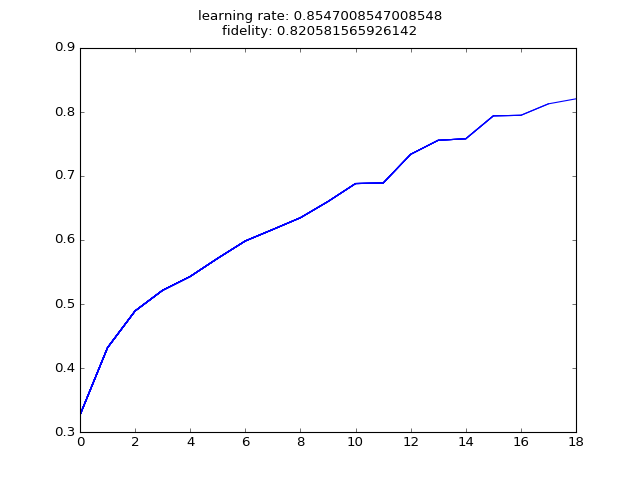

In [ ]:
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions='all'
#     J=new_Jvalues
)
qn.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=10,
    target_gate=halfadder,
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
#     saveafter_file='nets/fredkin_best.pickle'
)

In [214]:
net = load_network_from_file('nets/fredkin_best.pickle')
print('Fidelity: {}'.format(net.test_fidelity(n_samples=100)))
print_OrderedDict(net.get_interactions_with_Js())

Fidelity: 0.9999888243221936
{
    "(0, 'z')": -0.000333662301860085,
    "(1, 'z')": 6.295873063114542e-06,
    "(2, 'z')": -1.5789920842045073e-05,
    "(3, 'z')": 9.579454270364572e-05,
    "((0, 1), 'xx')": 0.34863724024265735,
    "((0, 1), 'xy')": 0.9582706440463985,
    "((0, 1), 'xz')": -3.3168073500153623,
    "((0, 1), 'yx')": 0.049602796808803765,
    "((0, 1), 'yy')": 0.2445595864036591,
    "((0, 1), 'yz')": -0.6908267943759873,
    "((0, 1), 'zx')": 0.32337908613543886,
    "((0, 1), 'zy')": 0.6556094754906853,
    "((0, 1), 'zz')": -1.8126523913711574,
    "((0, 2), 'xx')": 0.34762401063088344,
    "((0, 2), 'xy')": 0.9569518933450241,
    "((0, 2), 'xz')": -3.3158612784831463,
    "((0, 2), 'yx')": 0.049377162135457106,
    "((0, 2), 'yy')": 0.24368691265262135,
    "((0, 2), 'yz')": -0.6885749523511139,
    "((0, 2), 'zx')": -0.027830549638016466,
    "((0, 2), 'zy')": -0.24381668335866902,
    "((0, 2), 'zz')": 1.0724723104243927,
    "((0, 3), 'xx')": -0.968272064160

##### We get in this case a Fredkin if the ancilla is 0, and a Fredkin with opposite control if the ancilla is 1:

In [225]:
proj0 = qutip.tensor(qutip.qeye(2), qutip.qeye(2), qutip.qeye(2), qutip.projection(2, 0, 0))
proj1 = qutip.tensor(qutip.qeye(2), qutip.qeye(2), qutip.qeye(2), qutip.projection(2, 1, 1))
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

gate0 = chop((proj0 * gate * proj0).ptrace([0, 1, 2]))
gate0 = gate0 * np.exp(-1j * np.angle(gate0[0, 0]))
display(chop(gate0))

gate1 = chop((proj1 * gate * proj1).ptrace([0, 1, 2]))
gate1 = gate1 * np.exp(-1j * np.angle(gate1[0, 0]))
display(chop(gate1))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.99999506+0.j          0.00000000+0.j          0.00000000+0.j
  -0.00122103+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.99998824+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.99998861+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000-0.00104559j  0.00000000+0.j          0.00000000+0.j
   0.99999563+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.99999552+0.j          0.00000000+0.j
   0.00000000+0.j          0.0012

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.99999625+0.j          0.00000000+0.j          0.00000000+0.j
   0.00123388+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.99999563+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.99999540+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.00104826j  0.00000000+0.j          0.00000000+0.j
   0.99999551+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.99999554+0.j          0.00000000+0.j
   0.00000000+0.j         -0.0012

In [5]:
net.J.get_value()

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan])

[  8.98313281   8.37969149   9.3537639   10.8586698   11.88921396
   9.97753264   7.42805175   8.74198587  10.05316449   8.54294651
   9.89007296  10.46046354  10.09464282  10.48210736   8.97893472
   9.99305808]
Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


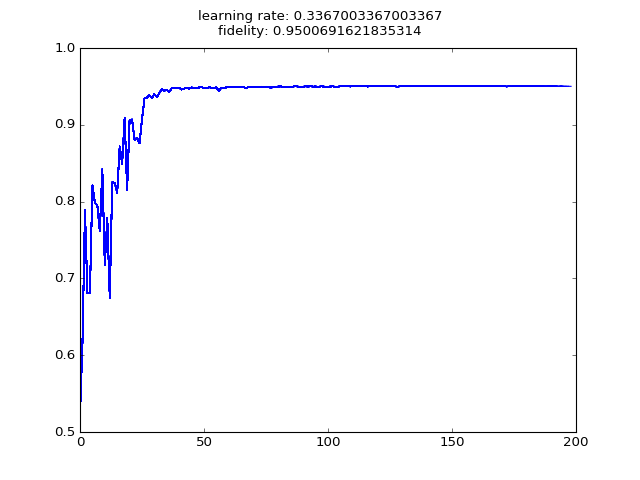

Finished training
Final fidelity: 0.9457288653266597


In [7]:
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['yy', 'zz', 'z'])
)
net.J.set_value(net.J.get_value() + 10. * np.ones_like(net.J.get_value()))
print(net.J.get_value())
sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


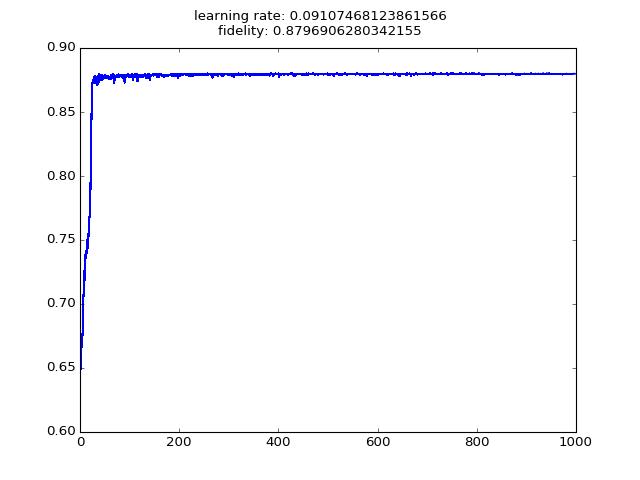

Finished training


In [180]:
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['yy', 'zz', 'z'])
)
sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


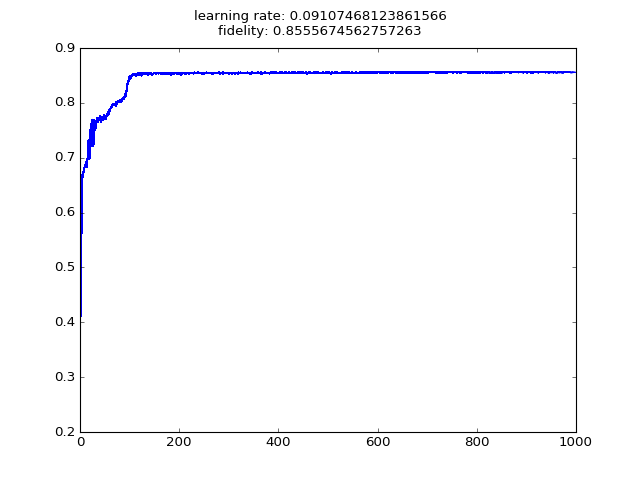

Finished training


In [182]:
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz', 'x', 'y', 'z'])
)
sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


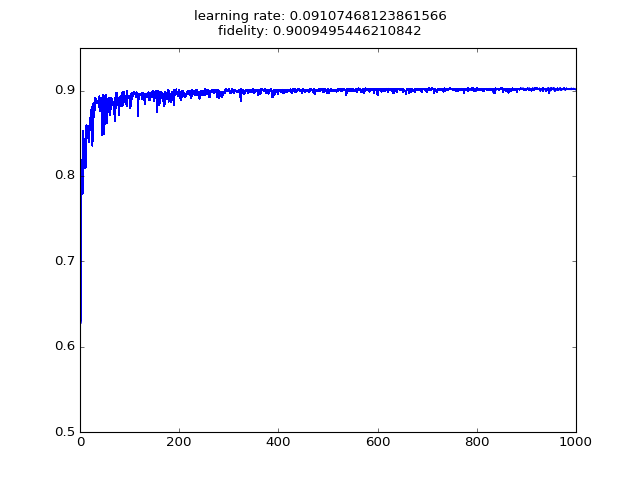

Finished training


In [184]:
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz', 'xy', 'x', 'y', 'z'])
)
sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [98]:
net = load_network_from_file('nets/fredkin_best.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

fred = gate.ptrace([0, 1, 2]).data.toarray()
fred[np.abs(fred) < 1e-3] = 0.0
fred = fred * np.exp(-1j * np.angle(fred[0, 0]))
fred.imag[abs(fred.imag) <  1e-3] = 0.0

qutip.Qobj(fred)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 1.99999127  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          1.00001791  0.99999623  0.          0.          0.          0.
   0.        ]
 [ 0.          0.99999402  0.99996561  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.99999111  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.99999109  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.99999012
   0.9999961   0.        ]
 [ 0.          0.          0.          0.          0.          0.99999413
   0.99999293  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.99999134]]

In [127]:
net = load_network_from_file('nets/fredkin_best.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

p00 = qutip.ket2dm(qutip.basis(2, 0))
p11 = qutip.ket2dm(qutip.basis(2, 1))
p01 = qutip.Qobj([[0, 1], [0, 0]])
p10 = qutip.Qobj([[0, 0], [1, 0]])

i3 = qutip.tensor([qutip.qeye(2) for _ in range(3)])
ntlp = utils.normalize_topleft_phase

extracted1 = (qutip.tensor(i3, p00) * gate * qutip.tensor(i3, p00)).ptrace([0, 1, 2])
extracted2 = (qutip.tensor(i3, p11) * gate * qutip.tensor(i3, p11)).ptrace([0, 1, 2])
extracted3 = (qutip.tensor(i3, p01) * gate * qutip.tensor(i3, p01)).ptrace([0, 1, 2])
extracted4 = (qutip.tensor(i3, p10) * gate * qutip.tensor(i3, p10)).ptrace([0, 1, 2])

display(chop(ntlp(chop(extracted1))))
display(ntlp(chop(extracted2)))
display(ntlp(chop(extracted3)))
display(ntlp(chop(extracted4)))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.38262553  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.38271334  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.38271012  0.          0.          0.          0.
   0.        ]
 [ 0.00113171  0.          0.          0.38268825  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.38260567  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.38270471  0.        ]
 [ 0.          0.          0.          0.          0.          0.38273547
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.38260234]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.38230036+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.38269167+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.38272269+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.38240083+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.38262003+0.j          0.00000000+0.j
   0.00000000+0.j          0.0000

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

In [134]:
Jvalues = net.J.get_value()
display(Jvalues)
# [net.J_index_to_interaction(v) for v in np.where(np.abs(Jvalues) < 1e-3)[0]]
# net.active_hs
Jvalues[[net.tuple_to_xs_index(((0, 2), 'xy')), net.tuple_to_xs_index(((1, 2), 'xy'))]]

array([ -3.33662302e-04,   6.29587306e-06,  -1.57899208e-05,
         9.57945427e-05,   3.48637240e-01,   9.58270644e-01,
        -3.31680735e+00,   4.96027968e-02,   2.44559586e-01,
        -6.90826794e-01,   3.23379086e-01,   6.55609475e-01,
        -1.81265239e+00,   3.47624011e-01,   9.56951893e-01,
        -3.31586128e+00,   4.93771621e-02,   2.43686913e-01,
        -6.88574952e-01,  -2.78305496e-02,  -2.43816683e-01,
         1.07247231e+00,  -9.68272064e-01,  -1.22447583e+00,
        -8.84021718e-04,   1.24402550e+00,  -9.69491489e-01,
         1.16198049e-03,   1.27472394e-03,   5.27919157e-03,
         2.35810340e+00,   7.67137183e-01,  -4.07293974e-02,
         1.72312350e-01,  -4.08734884e-02,   6.57406318e-01,
         4.79221787e-01,   1.73037299e-01,   4.79996568e-01,
        -1.03380509e+00,  -9.43497636e-02,  -9.22462741e-02,
         1.55768464e-01,  -1.02434314e-01,  -2.73949437e-01,
         4.65624355e-01,   4.73042385e-01,   9.47372533e-01,
        -1.61224118e+00,

array([ 0.32337909,  0.00127472])

In [177]:
groups = utils.group_similar_elements(Jvalues)
groups = [g for g in groups if len(g) > 1]

[[net.J_index_to_interaction(i) for i in groups[j]] for j in range(len(groups))]

[[(0, 'z'), (1, 'z'), (2, 'z'), (3, 'z'), ((0, 3), 'xz')],
 [((0, 1), 'xz'), ((0, 2), 'xz')],
 [((0, 1), 'yx'), ((0, 2), 'yx')],
 [((0, 1), 'yy'), ((0, 2), 'yy')],
 [((0, 3), 'yz'), ((0, 3), 'zx')],
 [((1, 2), 'xy'), ((1, 2), 'yx')],
 [((1, 2), 'xz'), ((1, 2), 'zx')],
 [((1, 2), 'yz'), ((1, 2), 'zy')],
 [((1, 3), 'xx'), ((2, 3), 'xx')],
 [((1, 3), 'xy'), ((2, 3), 'xy')],
 [((1, 3), 'yx'), ((2, 3), 'yx')]]